![image](https://docs.google.com/uc?export=download&id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d)


<h1><center><b>Redes Neuronales Convolucionales, Arquitecturas Neuronales y Aprendizaje Profundo</b></center></h1>
<h3><center><b>IMÁGENES Y VISIÓN</b></center></h3>



## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
7. [**Predicción**](#id7)
8. [**Validación**](#id8)
9. [**Trabajo Asíncrono**](#id9)

## **Objetivos**<a name="id1"></a>
- Entrar en materia con las Redes Neuronales Convolucionales.
- Conocer tácticas de aprendizaje y mejoras en el entrenamiento.
- Familiarizarse con el aprendizaje por transferencia.
- Entrar en más profundidad con los gadgets de `TensorFlow` y `Keras`.
- Aprender arquitecturas neuronales, sus ventajas y desventajas.

## **Problema**<a name="id2"></a>
- En un cultivo de gran área se busca hacer la clasificación de 9 especies que allí habitan, dado que hacen daño al ecosistema. El objetivo de la clasificación es identificar correctamente la planta, para respectiva su extracción.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_12()

shred: setup_colab.py: failed to open for writing: No such file or directory
shred: setup_colab_general.py: failed to open for writing: No such file or directory



General Functions Enabled Successfully



Util Functions Downloaded Successfully




Extracting Zip File...
Deleting File...



Dataset Downloaded Successfully



Pretrained Networks Downloaded Successfully
Workshop 12 Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

from skimage import io

from utils import general as gen
from utils import tf_utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

### **Carga de Datos**

In [ ]:
data_dir = gen.read_listdir("data")
labels = pd.read_csv("data/labels.csv")

In [ ]:
labels.head()

Filename  Label       Species
0  20160928-140314-0.jpg      0  Chinee apple
1  20160928-140337-0.jpg      0  Chinee apple
2  20160928-140731-0.jpg      0  Chinee apple
3  20160928-140747-0.jpg      0  Chinee apple
4  20160928-141107-0.jpg      0  Chinee apple

## **Visualización y Análisis Exploratorio**<a name="id4"></a>
- En esta ocación nos vamos a enfrentar al dataset *Deep Weeds*. Que es un dataset que busca clasificar distintas especies de maleza silvestre para efectuar un control de plagas vegetativas más certero. Las especies son las siguientes:
    - Chinee apple
    - Lantana
    - Negative
    - Parkinsonia
    - Parthenium
    - Prickly acacia
    - Rubber vine
    - Siam weed
    - Snake weed


In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(data_dir), 9)

In [ ]:
imgs = []
for i in random_sample:
    img = io.imread(data_dir[i])
    imgs.append(img)

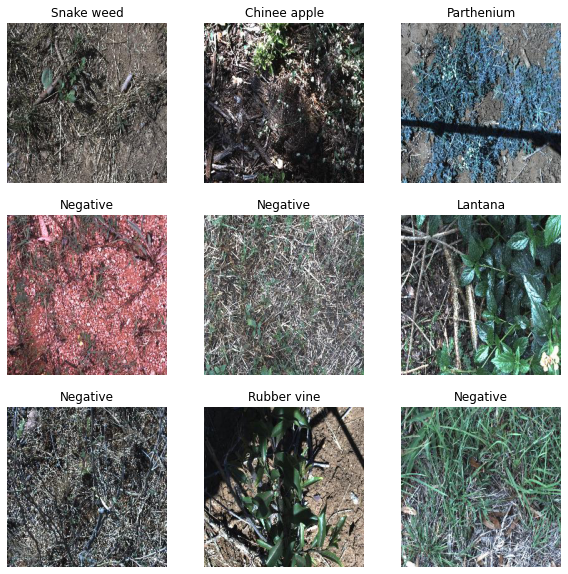

In [ ]:
gen.visualize_subplot(imgs, labels.loc[random_sample, "Species"].values, 
                      (3, 3), (10, 10))

In [ ]:
distribution = labels["Species"].value_counts().sort_index()

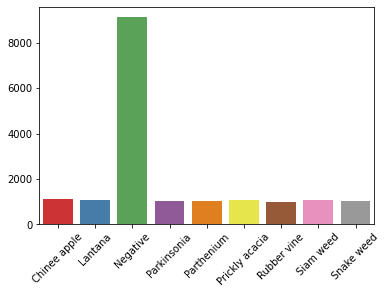

In [ ]:
ax = sns.barplot(x=distribution.index, y=distribution.values, palette="Set1")
ax.set_xticklabels(distribution.index, rotation=45)
plt.show()

In [ ]:
n_samples = 1100

In [ ]:
pos_class = labels.query("Label != 8")
neg_class = labels.query("Label == 8")

In [ ]:
neg_class_downsampled = resample(neg_class, replace=False, 
                                  n_samples=n_samples, 
                                  random_state=1234)

In [ ]:
labels_resampled = pd.concat([pos_class, neg_class_downsampled])

In [ ]:
labels_resampled.reset_index(drop=True, inplace=True)

In [ ]:
labels = labels_resampled.copy()

In [ ]:
labels["Species"].value_counts().sort_index()

Chinee apple      1125
Lantana           1064
Negative          1100
Parkinsonia       1031
Parthenium        1022
Prickly acacia    1062
Rubber vine       1009
Siam weed         1074
Snake weed        1016
Name: Species, dtype: int64

## **Preparación de los Datos**<a name="id5"></a>

In [ ]:
shuffle_split = ShuffleSplit(test_size=0.2, random_state=1234)

In [ ]:
for full_train_index, test_index in shuffle_split.split(labels):
    full_train_set = labels.loc[full_train_index]
    test_set = labels.loc[test_index]

In [ ]:
full_train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [ ]:
for train_index, val_index in shuffle_split.split(full_train_set):
    train_set = full_train_set.loc[train_index]
    val_set = full_train_set.loc[val_index]

In [ ]:
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True, 
                                   zoom_range=0.5,
                                   rescale=1/255.,
                                   rotation_range=10,
                                   brightness_range=[1, 1.5], 
                                   fill_mode="wrap")

val_dataget = ImageDataGenerator(rescale=1/255.)

In [ ]:
size = (128, 128)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_set, 
                                                    directory="data",
                                                    x_col="Filename", 
                                                    y_col="Species", 
                                                    target_size=size)

valid_generator = val_dataget.flow_from_dataframe(val_set, directory="data",
                                                  x_col="Filename", 
                                                  y_col="Species", 
                                                  target_size=size, 
                                                  shuffle=False, 
                                                  batch_size=16)

Found 6081 validated image filenames belonging to 9 classes.
Found 1521 validated image filenames belonging to 9 classes.


In [ ]:
np.random.seed(1234)
random_batch = np.random.randint(0, len(train_generator))
X_batch, y_batch = train_generator[random_batch]

In [ ]:
np.random.seed(1234)
random_sample = np.random.choice(len(X_batch), 9)
y_batch = labels.Species.unique()[ y_batch[random_sample].argmax(axis=1)]

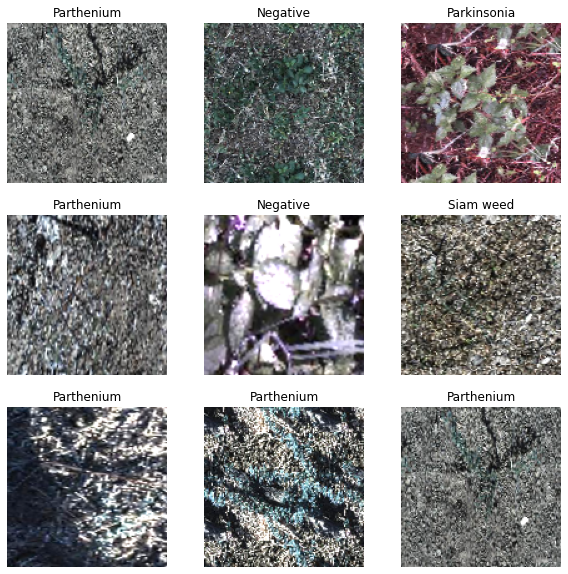

In [ ]:
gen.visualize_subplot(X_batch[random_sample], 
                      y_batch, (3, 3), (10, 10))

## **Modelamiento**<a name="id6"></a>
- Inception:

![image](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=es)

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "models/weights.h5"

In [ ]:
base_model = keras.applications.InceptionV3(include_top=False,
                                            weights="imagenet", 
                                            input_shape=(*size, 3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = tf_utils.DenseBlock(128)(global_avg)
dense_2 = tf_utils.DenseBlock(64)(dense_1)

output = keras.layers.Dense(9, activation="softmax")(dense_2)
model = keras.Model(inputs=base_model.inputs, outputs=output)

lr = 1e-3

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
              metrics=["acc"])
params = {
    "steps_per_epoch": train_generator.samples // train_generator.batch_size,
    "validation_steps": valid_generator.samples // valid_generator.batch_size,
    "epochs": 5,
    "validation_data": valid_generator
}

In [ ]:
history = model.fit(train_generator, **params)

Epoch 1/5
190/190 [==============================] - 40s 213ms/step - loss: 1.7436 - acc: 0.3771 - val_loss: 1.6257 - val_acc: 0.4388
Epoch 2/5
190/190 [==============================] - 39s 205ms/step - loss: 1.4895 - acc: 0.4733 - val_loss: 1.5510 - val_acc: 0.4513
Epoch 3/5
190/190 [==============================] - 39s 203ms/step - loss: 1.4282 - acc: 0.4887 - val_loss: 1.4041 - val_acc: 0.4888
Epoch 4/5
190/190 [==============================] - 39s 205ms/step - loss: 1.3956 - acc: 0.5012 - val_loss: 1.4132 - val_acc: 0.4974
Epoch 5/5
190/190 [==============================] - 39s 204ms/step - loss: 1.3714 - acc: 0.5108 - val_loss: 1.3457 - val_acc: 0.5105


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### **Adam Optimizer**
- Adam se refiere a *adaptative moment estimation*, y es un optimizador rápido con buen grado de convergencia, es ampliamente usado y es una variación más de SGD.
- He aquí una tabla con las características de los mejores optimizadores.

|Class|Convergence Speed|Convergence Quality|
|---|---|---|
|SGD|*|***|
|SGD(momentum=...)|**|***|
|SGD(momentum=..., nesterov=True)|**|***|
|Adagrad|***|* (Se detiene muy antes)|
|RMSprop|***|** o ***|
|Adam|***|** o ***|
|Nadam|***|** o ***|
|AdaMax|***|** o ***|

In [ ]:
optimizer = keras.optimizers.Adam(lr=lr)
metrics = [keras.metrics.Precision(name="Precision"), 
           keras.metrics.Recall(name="Recall"), "accuracy"]

callbacks = [tf_utils.CustomCallback(weights_dir, patience=5)]

model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
              metrics=metrics)

In [ ]:
params = {
    "steps_per_epoch": train_generator.samples // train_generator.batch_size,
    "validation_steps": valid_generator.samples // valid_generator.batch_size,
    "callbacks": callbacks,
    "epochs": 10,
    "validation_data": valid_generator
}

In [ ]:
history = model.fit(train_generator, **params)

Epoch 1/10
190/190 [==============================] - ETA: 0s - loss: 1.5616 - Precision: 0.6065 - Recall: 0.2311 - accuracy: 0.4353
Best Weights Saved!!
190/190 [==============================] - 45s 235ms/step - loss: 1.5616 - Precision: 0.6065 - Recall: 0.2311 - accuracy: 0.4353 - val_loss: 2.0819 - val_Precision: 0.4684 - val_Recall: 0.3362 - val_accuracy: 0.4151
Epoch 2/10
190/190 [==============================] - ETA: 0s - loss: 1.2304 - Precision: 0.6985 - Recall: 0.4087 - accuracy: 0.5631
Best Weights Saved!!
190/190 [==============================] - 43s 228ms/step - loss: 1.2304 - Precision: 0.6985 - Recall: 0.4087 - accuracy: 0.5631 - val_loss: 3.3459 - val_Precision: 0.4659 - val_Recall: 0.3730 - val_accuracy: 0.4276
Epoch 3/10
190/190 [==============================] - ETA: 0s - loss: 1.0976 - Precision: 0.7203 - Recall: 0.4857 - accuracy: 0.6148
Best Weights Saved!!
190/190 [==============================] - 43s 227ms/step - loss: 1.0976 - Precision: 0.7203 - Recall: 0.4

## **Predicción**<a name="id7"></a>



In [ ]:
inception_dir = "models/inception.h5"

if os.path.exists(inception_dir):
    model.load_weights(inception_dir)
    print("Weights Loaded!!")
    lr = 1e-4

Weights Loaded!!


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(test_set, directory="data", 
                                                  x_col="Filename", 
                                                  y_col="Species", 
                                                  target_size=size, 
                                                  shuffle=False, 
                                                  batch_size=16)

Found 1901 validated image filenames belonging to 9 classes.


In [ ]:
np.random.seed(1234)
random_batch = np.random.randint(0, len(test_generator))
X_batch, y_batch = test_generator[random_batch]

In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(X_batch), 9)

In [ ]:
y_pred = model.predict(X_batch[random_sample])
y_pred = labels["Species"].unique()[y_pred.argmax(axis=1)]

In [ ]:
y_batch = labels["Species"].unique()[y_batch[random_sample].argmax(axis=1)]

In [ ]:
titles = [f"{y_t} - {y_p}" for y_t, y_p in zip(y_batch, y_pred)]

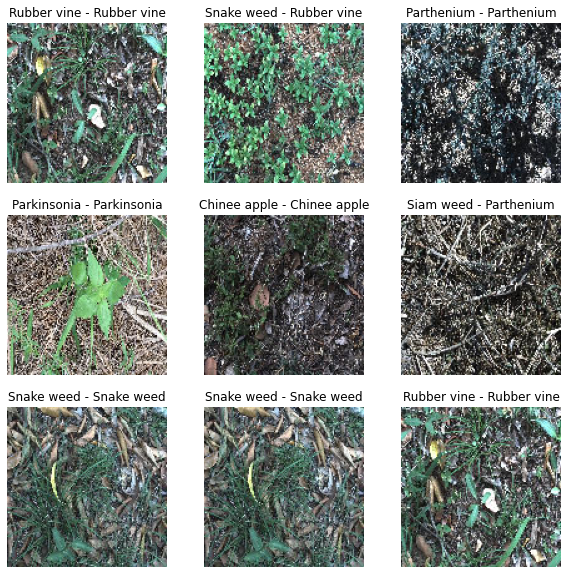

In [ ]:
gen.visualize_subplot(
    X_batch[random_sample], 
    titles, (3, 3), (10, 10)
)

## **Validación**<a name="id8"></a>

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator)

119/119 [==============================] - 4s 36ms/step - loss: 0.2964 - Precision: 0.9139 - Recall: 0.8937 - accuracy: 0.9037


In [ ]:
loss

0.2963697612285614

In [ ]:
precision

0.913932204246521

In [ ]:
recall

0.8937401175498962

In [ ]:
acc

0.9037348628044128

In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
conf_matrix = confusion_matrix(test_generator.labels, y_pred)

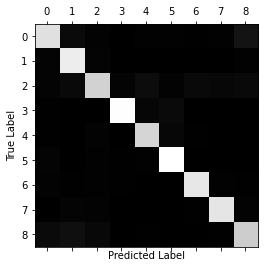

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

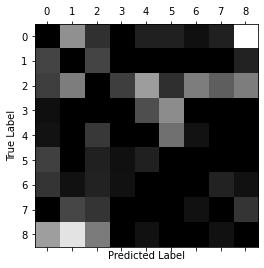

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **Trabajo Asíncrono**<a name="id9"></a>
1. Investigue sobre las redes convolucionales pre-entrenadas que vienen incorporadas en `keras.applications` y seleccione una para resolver el problema propuesto del taller (conjunto de datos DeepWeeds). Justifique por qué la está usando (máximo un párrafo) y compare métricas de desempeño sobre el test set con respecto a los arrojados por la arquitectura del taller.
2. Ahora, tome un dataset de los que vienen incorporados en [TensorFlow](https://www.tensorflow.org/datasets/catalog/overview?hl=es-419) y resuelva el problema de clasificación asociado usando aprendizaje por transferencia (No está permitido seleccionar un dataset de la familia MNIST, ni tampoco el dataset del proyecto).
3. Desarrolle su propio [callback](https://www.tensorflow.org/guide/keras/custom_callback?hl=es-419) para resolver nuevamente el problema del punto anterior.

## **Punto 1** </a>

<p align="justify">
Para comparar el desempeño del modelo previamente desarrollado se propuso incialmente el uso de la red preentrenda de Keras Xception. Esta red es considerada como la versión siguiente de inceptionv3 y por ende el resultado que nos gustaria comprobar son las mejoras en las metricas de comparación de ambos modelos. <br> Aún así el desempeño que se obtuvo al final para este modelamiento fue menor frente al modelo inception por lo cual se decidio cambiar y usar la red ResNET50.






Orginalmente el nombre de Xception videne de una version extrema de inception, y uno de los principales cambios gira entorno al orden en el cual se dan las de convoluciones separables de profundidad. En Xception se realiza una convolución puntual 1x1 para modificar la dimensión y seguido a esto se aplican una convolución profunda o espacial nxn en cada canal. El objetivo de esto es no necesitar realizar convoluciones a lo largo de todos los canales y hacer el modelo un poco mas ligero. Esto también se puede apreciar en la cantidad de parametros y profundidad de ambas arquitecturas por un lado Xception tiene un total de 22.910.480 párametros y una profundidad de126 capas, frente a InceptionV3, que cuenta con 23.851.784 parámetros y una profundidad de 159 capas.


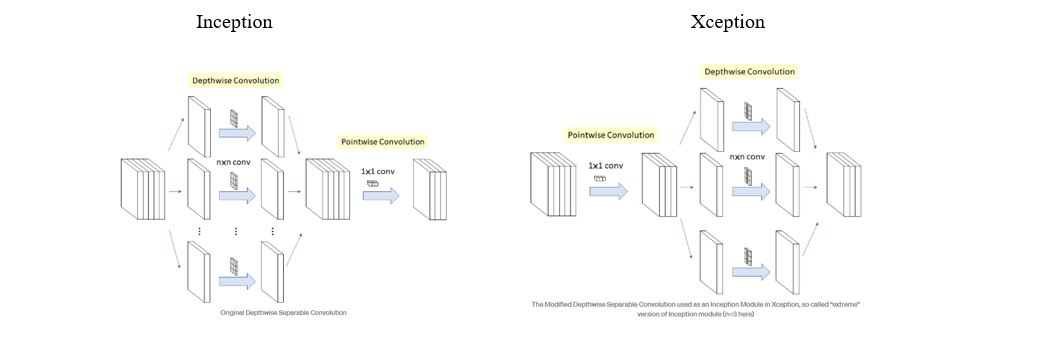

Seguido a esto, procedemos a replicar el proceso desarrollado con el modelo InceptiónV3 pero ahora con el modelo Xception.

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "/content/models/xception_weights.h5"

In [ ]:
base_model = keras.applications.Xception(include_top=False,
                                            weights="imagenet", 
                                            input_shape=(*size, 3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = tf_utils.DenseBlock(128)(global_avg)
dense_2 = tf_utils.DenseBlock(64)(dense_1)

output = keras.layers.Dense(9, activation="softmax")(dense_2)
model = keras.Model(inputs=base_model.inputs, outputs=output)

lr = 1e-3

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
              metrics=["acc"])
params = {
    "steps_per_epoch": train_generator.samples // train_generator.batch_size,
    "validation_steps": valid_generator.samples // valid_generator.batch_size,
    "epochs": 5,
    "validation_data": valid_generator
}

In [ ]:
history = model.fit(train_generator, **params)

Epoch 1/5
190/190 [==============================] - 41s 217ms/step - loss: 1.7868 - acc: 0.3763 - val_loss: 1.7169 - val_acc: 0.4164
Epoch 2/5
190/190 [==============================] - 40s 213ms/step - loss: 1.4649 - acc: 0.4683 - val_loss: 1.4573 - val_acc: 0.5158
Epoch 3/5
190/190 [==============================] - 40s 212ms/step - loss: 1.4219 - acc: 0.4912 - val_loss: 1.4048 - val_acc: 0.5112
Epoch 4/5
190/190 [==============================] - 40s 212ms/step - loss: 1.3512 - acc: 0.5186 - val_loss: 1.3139 - val_acc: 0.5461
Epoch 5/5
190/190 [==============================] - 40s 213ms/step - loss: 1.3331 - acc: 0.5245 - val_loss: 1.3532 - val_acc: 0.5276


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.Adam(lr=lr)
metrics = [keras.metrics.Precision(name="Precision"), 
           keras.metrics.Recall(name="Recall"), "accuracy"]

callbacks = [tf_utils.CustomCallback(weights_dir, patience=5)]

model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
              metrics=metrics)

params = {
    "steps_per_epoch": train_generator.samples // train_generator.batch_size,
    "validation_steps": valid_generator.samples // valid_generator.batch_size,
    "callbacks": callbacks,
    "epochs": 10,
    "validation_data": valid_generator
}

In [ ]:
history = model.fit(train_generator, **params)

Epoch 1/10
190/190 [==============================] - ETA: 0s - loss: 1.3190 - Precision: 0.6803 - Recall: 0.3855 - accuracy: 0.5305
Best Weights Saved!!
190/190 [==============================] - 53s 279ms/step - loss: 1.3190 - Precision: 0.6803 - Recall: 0.3855 - accuracy: 0.5305 - val_loss: 1.3244 - val_Precision: 0.6322 - val_Recall: 0.4862 - val_accuracy: 0.5592
Epoch 2/10
190/190 [==============================] - ETA: 0s - loss: 0.9137 - Precision: 0.7748 - Recall: 0.5887 - accuracy: 0.6823
Best Weights Saved!!
190/190 [==============================] - 51s 271ms/step - loss: 0.9137 - Precision: 0.7748 - Recall: 0.5887 - accuracy: 0.6823 - val_loss: 1.2046 - val_Precision: 0.6843 - val_Recall: 0.5961 - val_accuracy: 0.6467
Epoch 3/10
190/190 [==============================] - 51s 268ms/step - loss: 0.7588 - Precision: 0.8147 - Recall: 0.6768 - accuracy: 0.7443 - val_loss: 1.3791 - val_Precision: 0.6519 - val_Recall: 0.5914 - val_accuracy: 0.6217
Epoch 4/10
190/190 [=============

In [ ]:
Xception_dir = "/content/models/xception_weights.h5"

if os.path.exists(Xception_dir):
    model.load_weights(Xception_dir)
    print("Weights Loaded!!")
    lr = 1e-4

Weights Loaded!!


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(test_set, directory="data", 
                                                  x_col="Filename", 
                                                  y_col="Species", 
                                                  target_size=size, 
                                                  shuffle=False, 
                                                  batch_size=16)

Found 1901 validated image filenames belonging to 9 classes.


In [ ]:
np.random.seed(1234)
random_batch = np.random.randint(0, len(test_generator))
X_batch, y_batch = test_generator[random_batch]

In [ ]:
np.random.seed(5678)
random_sample = np.random.choice(len(X_batch), 9)

In [ ]:
y_pred = model.predict(X_batch[random_sample])
y_pred = labels["Species"].unique()[y_pred.argmax(axis=1)]

In [ ]:
y_batch = labels["Species"].unique()[y_batch[random_sample].argmax(axis=1)]

In [ ]:
titles = [f"{y_t} - {y_p}" for y_t, y_p in zip(y_batch, y_pred)]

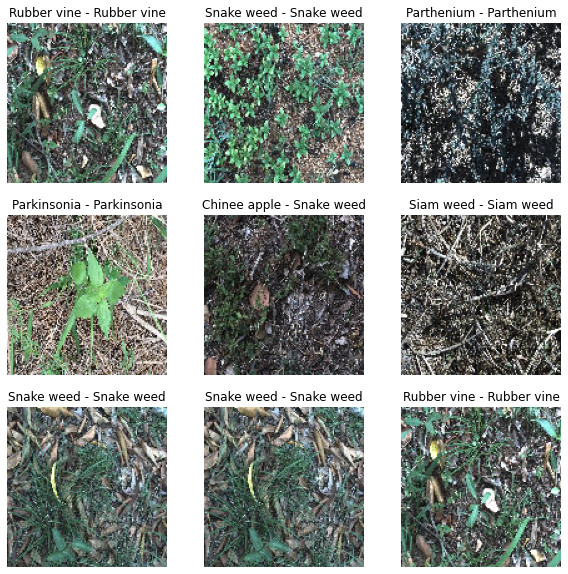

In [ ]:
gen.visualize_subplot(
    X_batch[random_sample], 
    titles, (3, 3), (10, 10)
)

Métricas de evaluación

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator)

119/119 [==============================] - 4s 36ms/step - loss: 0.4905 - Precision: 0.8747 - Recall: 0.8043 - accuracy: 0.8317


In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
conf_matrix = confusion_matrix(test_generator.labels, y_pred)

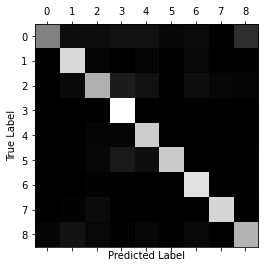

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

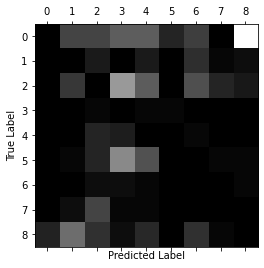

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<p align="justify">
Por ultimo, presentamos la comparación de los resultados obtenidos entre los diferentes modelos que se evaluaron.El mejor desempeño se encontró con la red Inceptión y el segundo modelo con el mejo desempeño fue la arquitectura Xception. Aún así, hay algunos comportamientos comunes, como que por ejemplo ambos modelos presentaron una gran dificultad con la clasificación de la categoria 1 la cual fue erroneamente clasificada como categoria 8. Cabe aclarar que los hyperparámretros principales se manejaron tal cual, que en el modelamiento que se realizo para la red Inception y por ende variaciones de estos puedes llevar cambios significtivos, pero bajos las mismas metricas, con el desarrollo obtenido, el mejor modelo obtenido fue Inception. El modelo Xception se entreno con una mayor cantidad de épocas pero al final el resultado al que se llego fue menos preciso que con un entrenamiento con solo 10 épocas. 

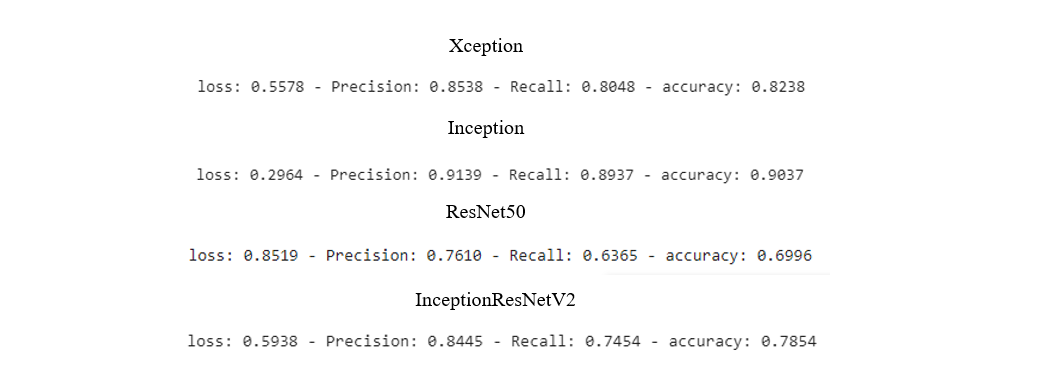

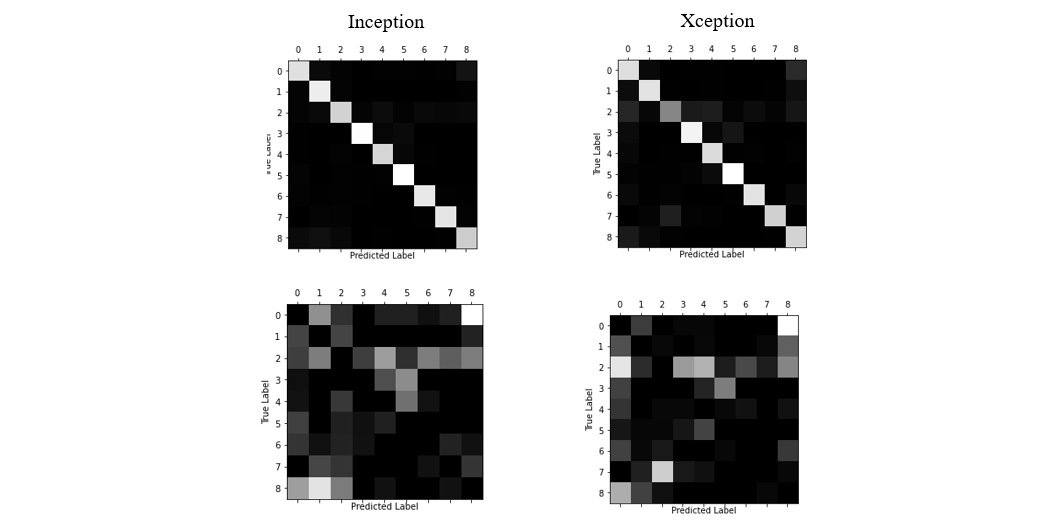

## **Punto 2** </a>

Se seleccionó el dataset de "horses_or_humans" porque tiene una cantidad considerable pero no extrema de imágenes y adicionalmente porque consideramos que es un dataset util en el mundo real. Se pueden llegar a considerar entrenamientos con datos simulados y seguido a esto, evaluar el desempeño en datos reales.

Este dataset cuenta con 2 categorías, humanos (1), y caballos (0), adicional a esto todas las imágenes son renders 3d. 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "horses_or_humans",
    split=["train[:80%]", "train[80%:100%]", "test"],
    as_supervised=True, 
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 822
Number of validation samples: 205
Number of test samples: 256


Como se puede ver para el desarrollo nuestro dataset se encuentra dividido de la siguiente forma:


*   822 imágenes de entrenamiento
*   205 imágenes de validación
*   256 imágenes de Test



**Etapa de preprocesamiento y exploración**

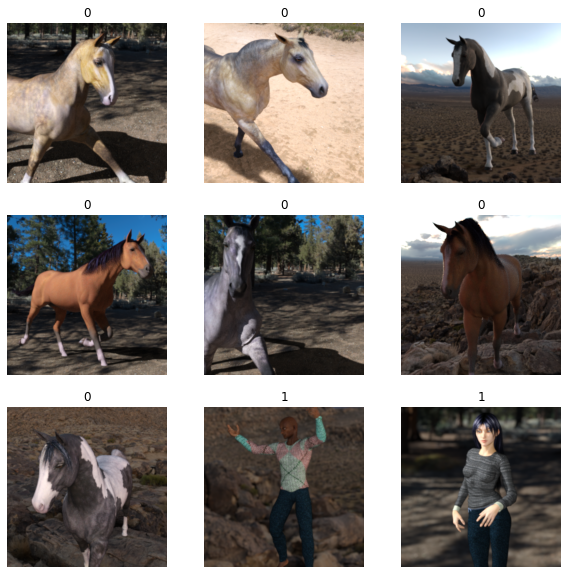

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

Al igual que en el procedimiento del laboratorio se realiza una aumentación de los datos.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

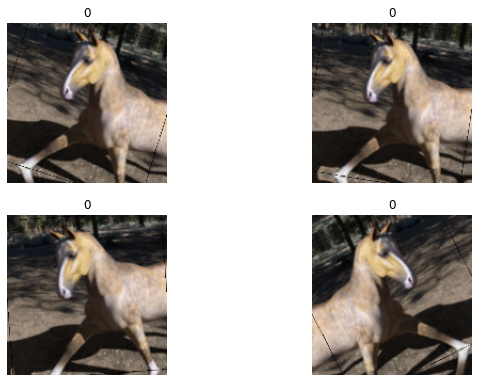

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(4):
        ax = plt.subplot(3, 2, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Etapa de modelado preliminar**

Para realizar la clasificación de este modelo se procedio a utilizar la red Xception

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  
    input_shape=(150, 150, 3),
    include_top=False,
)  

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],

)

In [ ]:
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
26/26 [==============================] - 5s 176ms/step - loss: 0.3047 - binary_accuracy: 0.8698 - val_loss: 0.0759 - val_binary_accuracy: 0.9902
Epoch 2/20
26/26 [==============================] - 2s 78ms/step - loss: 0.0793 - binary_accuracy: 0.9805 - val_loss: 0.0346 - val_binary_accuracy: 1.0000
Epoch 3/20
26/26 [==============================] - 2s 78ms/step - loss: 0.0543 - binary_accuracy: 0.9842 - val_loss: 0.0267 - val_binary_accuracy: 1.0000
Epoch 4/20
26/26 [==============================] - 2s 78ms/step - loss: 0.0397 - binary_accuracy: 0.9951 - val_loss: 0.0180 - val_binary_accuracy: 1.0000
Epoch 5/20
26/26 [==============================] - 2s 78ms/step - loss: 0.0347 - binary_accuracy: 0.9891 - val_loss: 0.0136 - val_binary_accuracy: 1.0000
Epoch 6/20
26/26 [==============================] - 2s 79ms/step - loss: 0.0355 - binary_accuracy: 0.9951 - val_loss: 0.0139 - val_binary_accuracy: 1.0000
Epoch 7/20
26/26 [==============================] - 2s 80ms/step - lo

Como se puede ver, inicialmente se ve un alto desempeño por parte del modelo, cerca de la epoca dos ya se presenta un accuracy en la validación binaría de 1. 

**Etapa de fine tuning**

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

26/26 [==============================] - 9s 344ms/step - loss: 0.0062 - binary_accuracy: 0.9988 - val_loss: 5.5957e-04 - val_binary_accuracy: 1.0000
Epoch 2/10
26/26 [==============================] - 8s 322ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 2.3221e-04 - val_binary_accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 8s 326ms/step - loss: 0.0033 - binary_accuracy: 0.9988 - val_loss: 1.4399e-04 - val_binary_accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 8s 325ms/step - loss: 4.0179e-04 - binary_accuracy: 1.0000 - val_loss: 1.7502e-04 - val_binary_accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 8s 318ms/step - loss: 5.6776e-04 - binary_accuracy: 1.0000 - val_loss: 8.5284e-05 - val_binary_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 8s 318ms/step - loss: 0.0018 - binary_accuracy: 0.9988 - val_loss: 1.4868e-04 - val_binary_accuracy: 1.0000
Epoch 7/10
26/26 [=========================

## **Punto 3** </a>

Para este punto se usó exactamente el mismo workflow del punto 2 con la excepción de que se agregaron algunos callbacks "personalizados". El objetivo es evaluar el desempeño de nuestro modelo bajo una metricas diferentes a las desarrolladas previamente.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "horses_or_humans",
    split=["train[:80%]", "train[80%:100%]", "test"],
    as_supervised=True, 
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 822
Number of validation samples: 205
Number of test samples: 256


In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

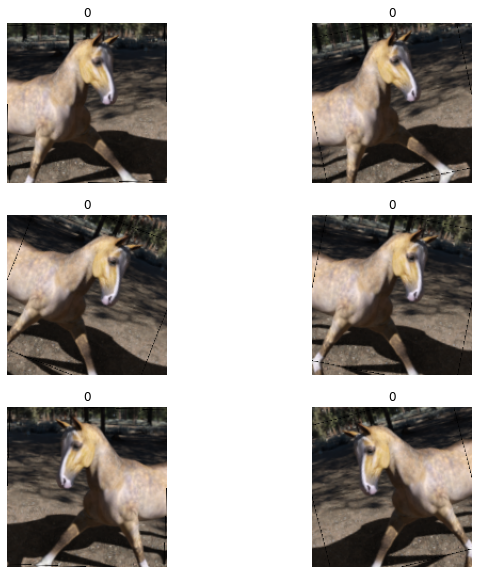

In [ ]:
import numpy as np
from IPython.display import clear_output


for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  
    input_shape=(150, 150, 3),
    include_top=False,
)  

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

x = norm_layer(x)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
import datetime
class CustomCallback(keras.callbacks.Callback):


    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Empezando entrenamiento")

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Entrenamiento finalizado")

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Consultando seres del más allá")

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Seres del más allá consultados")


    def on_train_batch_begin(self, batch, logs=None):
      print('Todo comenzo a las {}'.format(datetime.datetime.now().time()))
      print('Estamos en el batch {}'.format(batch))


    def on_train_batch_end(self, batch, logs=None):
      print(' Todo finalizo a las{}'.format(datetime.datetime.now().time()))

<p align="justify">
A continuación se implementaron unos callbacks sencillos, con el objetivo de entender el funcionamiento de los mismos. Primero se pensaron dos callbacks para avisar el momento en el cual comienza y finaliza el entrenamiento. Y seguido a esto, se utilizaron otros dos callbacks para medir el tiempo que tarda el entrenamiento de cada uno de los batch en cada epoca de la red y no solo conocer el tiempo que tarda el entrenamiento de cada época, adicionalmente podemos conocer batch en el que nos encontramos. 

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='Binary_Accuracy')]

)

In [ ]:
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[CustomCallback()])

Empezando entrenamiento
Epoch 1/20
Todo comenzo a las 03:35:27.042958
Estamos en el batch 0
 Todo finalizo a las03:35:29.356566
 1/26 [>.............................] - ETA: 0s - loss: 3.2083e-04 - Binary_Accuracy: 1.0000Todo comenzo a las 03:35:29.358166
Estamos en el batch 1
 Todo finalizo a las03:35:29.448012
 2/26 [=>............................] - ETA: 1s - loss: 5.2532e-04 - Binary_Accuracy: 1.0000Todo comenzo a las 03:35:29.449001
Estamos en el batch 2
 Todo finalizo a las03:35:29.515959
 3/26 [==>...........................] - ETA: 1s - loss: 0.0013 - Binary_Accuracy: 1.0000    Todo comenzo a las 03:35:29.516715
Estamos en el batch 3
 Todo finalizo a las03:35:29.578993
 4/26 [===>..........................] - ETA: 1s - loss: 0.0011 - Binary_Accuracy: 1.0000Todo comenzo a las 03:35:29.580083
Estamos en el batch 4
 Todo finalizo a las03:35:29.642408
 5/26 [====>.........................] - ETA: 1s - loss: 9.8014e-04 - Binary_Accuracy: 1.0000Todo comenzo a las 03:35:29.643186
Esta

<p align="justify">
Como se puede ver el funcionamiento de los callbacks se da de forma correcta, podemos apreciar que se detecta correctamente el comienzo y la finalización del entrenamiento y adicional a esto, se extraer de forma satisfactoria el número actual del batch y con la función datetime se calcula correctamente el tiempo del entrenamiento. Una funcionalidad que consideramos útil para el entrenamiento de modelos que tardan mucho tiempo.

Y por ultimo, se procedio a realizar la etapa de fine tunning. Como se vio en el punto anterior el modleo escogido se adapta muy bien al problema que estamos enfrentando (clasificar humanos o caballos). 

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[CustomCallback()])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

Todo comenzo a las 03:39:45.781700
Estamos en el batch 2
 Todo finalizo a las03:39:46.076287
 3/26 [==>...........................] - ETA: 4s - loss: 3.3475e-04 - binary_accuracy: 1.0000Todo comenzo a las 03:39:46.078117
Estamos en el batch 3
 Todo finalizo a las03:39:46.366483
 4/26 [===>..........................] - ETA: 4s - loss: 3.4205e-04 - binary_accuracy: 1.0000Todo comenzo a las 03:39:46.367613
Estamos en el batch 4
 Todo finalizo a las03:39:46.656718
 5/26 [====>.........................] - ETA: 4s - loss: 0.0017 - binary_accuracy: 1.0000    Todo comenzo a las 03:39:46.657920
Estamos en el batch 5
 Todo finalizo a las03:39:46.946386
 6/26 [=====>........................] - ETA: 4s - loss: 0.0014 - binary_accuracy: 1.0000Todo comenzo a las 03:39:46.947599
Estamos en el batch 6
 Todo finalizo a las03:39:47.235328
 7/26 [=======>......................] - ETA: 4s - loss: 0.0013 - binary_accuracy: 1.0000Todo comenzo a las 03:39:47.236584
Estamos en el batch 7
 Todo finalizo a las0

Finalmente para corroborar el desempeño obtenido se realiza la evaluación sobre el set de test.

In [ ]:
loss, bin = model.evaluate(test_ds)

8/8 [==============================] - 0s 58ms/step - loss: 0.0015 - binary_accuracy: 1.0000
